In [34]:
import numpy as np
import matplotlib.pyplot as plt 
import time as Time
import json
import gc
import tensorflow.keras.backend as K

from pinnPack.network import physicsNetwork
from pinnPack.initializer import genData
from pinnPack.optimizer import pinnOptimizer

from vizPack import utils
from ssfmPack import ssfm

In [35]:
gc.collect()
K.clear_session()

# SSFM Review

## Data Initialization

In [60]:
#Initializing sech pulse for initial data
def sechPulse(time, amplitude, pulse_width):
    return amplitude/np.cosh(time/pulse_width)

#Initialization of grid temporal parameter
timesteps = 2**12
dt = 0.1e-12
pulsewidth = 2**7*dt 
t = np.linspace(-10*pulsewidth, 10*pulsewidth, timesteps)

#Initializing fiber parameter
gamma = 10e-3 #Nonlinearity parameter in W/m
beta2 = -100e3 #Dispersion in fs^2/m
beta2 *= (1e-30) #Convert fs^2 into s^2
alpha = 0.2e-3*np.log(10)/10 #Power attenuation coef in Nepers/m

#Initialization of grid spatial parameter
zsteps = 2**15
z_char = np.pi/2*pulsewidth**2/np.abs(beta2) #Characteristic length 
ssfm_length = 5*z_char
z = np.linspace(0, ssfm_length, zsteps)

#Initial pulse 
N = 1
A = np.sqrt(np.abs(beta2)/gamma/pulsewidth**2)
init_pulse = sechPulse(t, A, pulsewidth)


## SSFM Method

In [63]:
ssfmStart = Time.time() 
pulseMatrix, spectrumMatrix = ssfm.SSFM(t, z, init_pulse,
                                           alpha, beta2, gamma)
ssfmStop = Time.time() 

ssfmTime = ssfmStop-ssfmStart

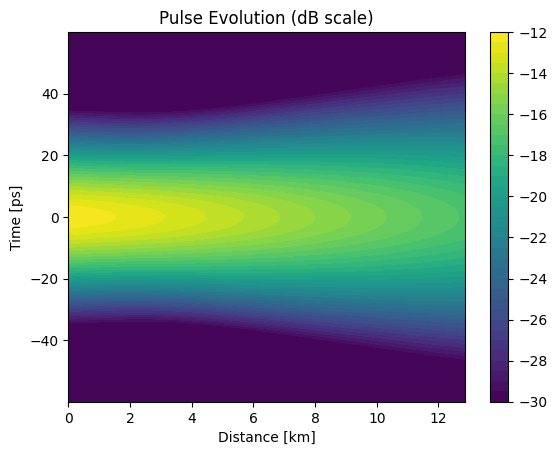

In [64]:
#Clip values within this range
ssfmrange = (t * 1e12 >= -60) & (t * 1e12 <= 60)
indices = np.where(ssfmrange)[0]
first_indice = indices[0]
last_indice = indices[-1]

#Create visualization
tS = t[indices]*1e12
zS = z/1000 
pulse = pulseMatrix[:, indices]

T_matrices,Z_matrices = np.meshgrid(tS, zS)
path = 'result/SSFM-viz.png'
utils.plotPulseContour(Z_matrices,T_matrices, pulse, path)

## Record Data

In [66]:
data = {
        'time': 60,
        'length': ssfm_length/1000,
        'time_records': ssfmTime
}

utils.updateJSON('ssfm', data)

Data Updated!


In [17]:
expected_pulse = ssfm.getPower(pulse)
np.save('result/ssfm/expected.npy', expected_pulse)
np.save('result/ssfm/expectedT.npy', T_matrices)
np.save('result/ssfm/expectedZ.npy', Z_matrices)

# PINN Review

## Initializing Collocation Point

In [18]:
#Initial pulse function
def sechPulsePINN(time, amplitude, pulse_width, T):
    time = time
    return amplitude/np.cosh(time*T/pulse_width)

pulsewidth = 0.1*2**7 

#Fiber parameter
gamma = 10 
beta2 = -100 
alpha = 0.2*np.log(10)/10 

z_char = np.pi/2*pulsewidth**2/np.abs(beta2)
pinn_length = 5*z_char 

#initial pulse
N = 1
A = np.sqrt(np.abs(beta2)/gamma/pulsewidth**2)

In [158]:
T = 60
L = pinn_length 

start_point = np.array([-1, 0]) #(t,x) = (-1,0)
final_point = np.array([1, 1]) #(t,x) = (1,1)

#Declaring numbers of collocation points and labelled points 
col_points = 7200
label_points = 500

In [159]:
t_initial = genData.generate_points(final_point[0], start_point[0], label_points)
x_boundary = genData.generate_points(final_point[-1], start_point[-1], label_points)

#initial condition (x = 0)
initial_tx = np.c_[t_initial, 
                   np.zeros((label_points, 1))]
u_init = sechPulsePINN(initial_tx[..., 0], A, pulsewidth, T).reshape(-1,1) #real part
initial_uv = np.c_[u_init, np.zeros_like(u_init)]

#lower boundary condition (t = t_init)
lower_tx = np.c_[np.full((label_points, 1), start_point[0]),
                 x_boundary]
lower_uv = np.zeros((label_points, 2))

#upper boundary condition (t = t_f)
upper_tx = np.c_[np.full((label_points, 1), final_point[0]),
                 x_boundary]
upper_uv = np.zeros((label_points, 2)) 

#collocation point 
col_point = genData.generate_points(final_point, start_point, col_points)
col_uv = np.zeros((col_points, 2)) 

#labelled point 
label_point = np.concatenate([initial_tx, lower_tx, upper_tx]) 
label_uv = np.concatenate([initial_uv, lower_uv, upper_uv])

In [160]:
# Validation data
expected_pulse = np.load('result/ssfm/expected.npy')
expected_T = np.load('result/ssfm/expectedT.npy')/T
expected_Z = np.load('result/ssfm/expectedZ.npy')/L

dimension = expected_pulse.shape

collocation_val = 5000
collocation_index = genData.generate_points(np.array([0,0]), dimension, collocation_val)
initial_index = np.c_[np.arange(0,1024,1), np.zeros((1024))]
validation_index = np.concatenate([collocation_index, initial_index]).astype(int)

valid_point = np.c_[expected_T[validation_index[:, 0], validation_index[:, 1]],
                    expected_Z[validation_index[:, 0], validation_index[:, 1]]
                    ]
valid_pulse = expected_pulse[validation_index[:, 0], validation_index[:, 1]].reshape(-1,1)


In [161]:
label_data = genData.batch_data(label_point, label_uv) 
col_data = genData.batch_data(col_point, col_uv)
val_data = genData.batch_data(valid_point, valid_pulse)

## Initializing Model

In [174]:
model_name = 'longprop_model_bfgs'
layers = [64, 64, 64, 64, 64]
model = physicsNetwork.build(layers = layers)

## Fit Model

In [175]:
optimizer = pinnOptimizer(model, col_data, label_data, val_data, T, L, alpha, beta2, gamma)
adam_epochs = 0
bfgs_epochs = 16
optimizer.fit(adam_epochs, bfgs_epochs)

Adam_Epochs: 0epoch [00:00, ?epoch/s]
Adam_Epochs: 0epoch [00:00, ?epoch/s]och/s]


Processing using ADAM Optimalization strategies
Processing using L-BFGS Optimalization strategies



LBFGS_Epochs:   0% 0/16 [00:13<?, ?epoch/s, Training Loss=5.2569e-02, Validation Loss=2.2083e-04]
LBFGS_Epochs:   6% 1/16 [00:13<03:18, 13.22s/epoch, Training Loss=5.2569e-02, Validation Loss=2.2083e-04]
LBFGS_Epochs:   6% 1/16 [00:22<03:18, 13.22s/epoch, Training Loss=3.8157e-04, Validation Loss=2.1963e-04]
LBFGS_Epochs:  12% 2/16 [00:22<02:33, 10.95s/epoch, Training Loss=3.8157e-04, Validation Loss=2.1963e-04]
LBFGS_Epochs:  12% 2/16 [00:35<02:33, 10.95s/epoch, Training Loss=1.2543e-04, Validation Loss=2.2024e-04]
LBFGS_Epochs:  19% 3/16 [00:35<02:35, 11.94s/epoch, Training Loss=1.2543e-04, Validation Loss=2.2024e-04]
LBFGS_Epochs:  19% 3/16 [00:37<02:35, 11.94s/epoch, Training Loss=7.9132e-05, Validation Loss=2.2024e-04]
LBFGS_Epochs:  25% 4/16 [00:37<01:34,  7.88s/epoch, Training Loss=7.9132e-05, Validation Loss=2.2024e-04]
LBFGS_Epochs:  25% 4/16 [00:39<01:34,  7.88s/epoch, Training Loss=7.9131e-05, Validation Loss=2.2024e-04]
LBFGS_Epochs:  31% 5/16 [00:39<01:02,  5.65s/epoch, T

In [176]:
t_array = np.linspace(start_point[0], final_point[0], 200)
zlocs = np.linspace(start_point[1], final_point[1], 800)
T_matrices, Z_matrices = np.meshgrid(t_array, zlocs)
tZ = np.stack((T_matrices.flatten(), Z_matrices.flatten()), axis = -1)

result = model.predict(tZ)

result_u = result[:, 0].reshape(Z_matrices.shape)
result_v = result[:, 1].reshape(Z_matrices.shape)


5000/5000 [==============================] - 7s 1ms/step


In [177]:
result_ = result_u + 1j*result_v

## Visualize Data

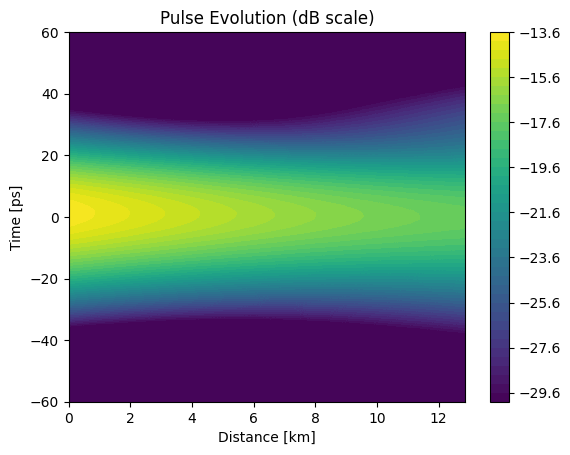

In [178]:
path = f'result/model/{model_name}/PINN-viz.png'
utils.plotPulseContour(Z_matrices*L,T_matrices*T, result_, path)

## Record Data

In [179]:
#Data Record
model.save(f'result/model/{model_name}')

data = {
        'time': T,
        'length': L,
        'collocation_points': col_points,
        'labelled_points': label_points,
        'layers': layers,
        'adam_epochs': adam_epochs,
        'bfgs_epochs': bfgs_epochs,
        'loss_records': [i.numpy().item() for i in optimizer.loss_records],
        'validation_records': [i.numpy().item() for i in optimizer.validation_records],
        'time_records': optimizer.time_records
}

utils.updateJSON(model_name, data)

INFO:tensorflow:Assets written to: result/model/longprop_model_bfgs/assets
Data Updated!


# Open Records

In [2]:
with open("result/report.json", "r") as file:
    loaded = json.load(file)

In [3]:
loaded.keys()

dict_keys(['model1', 'longprop_model', 'longprop_model_adam', 'longprop_model_bfgs'])

In [79]:
keys = list(loaded.keys())[1:]

In [4]:
losses = [loaded[i]['loss_records'] for i in loaded.keys()][1:]

In [5]:
time = [loaded[i]['time_records'] for i in loaded.keys()][1:]

In [28]:
validation = [loaded[i]['validation_records'] for i in loaded.keys()][1:]

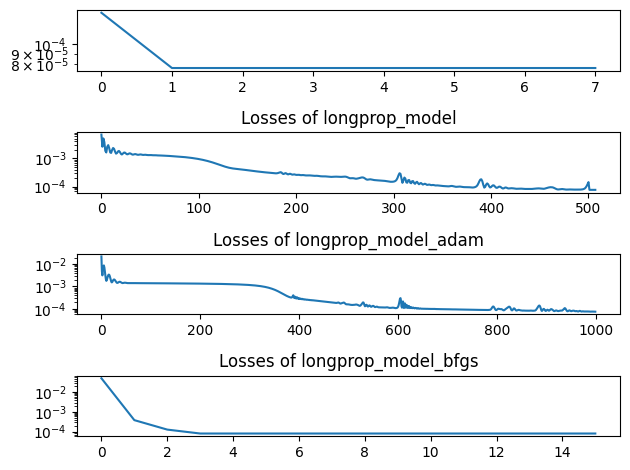

In [87]:
fig, ax = plt.subplots(4,1)
ax[0].plot(losses[0][-8:])
ax[0].set_yscale('log')
for i in range(1,4):
    ax[i].set_yscale('log')
    ax[i].set_title(f'Losses of {keys[i-1]}')
    if i !=0:
        ax[i].plot(losses[i-1])
    plt.tight_layout()

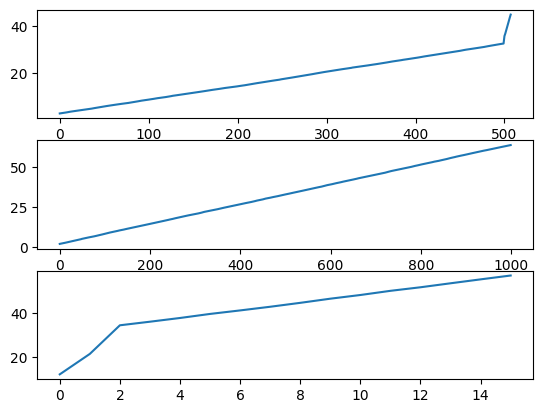

In [27]:
fig, ax = plt.subplots(3,1)
for i in range(3):
    ax[i].plot(time[i])

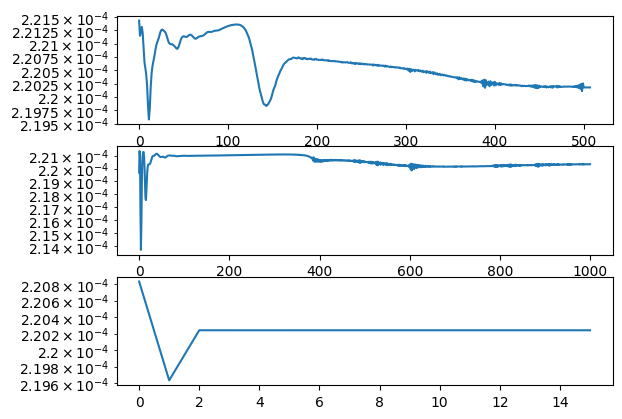

In [31]:
fig, ax = plt.subplots(3,1)
for i in range(3):
    ax[i].set_yscale('log')
    ax[i].plot(validation[i])